In [1]:
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import csv
import utm
import json
import pandas as pd
import os
import sys
import random
%matplotlib inline

# Show Visualization

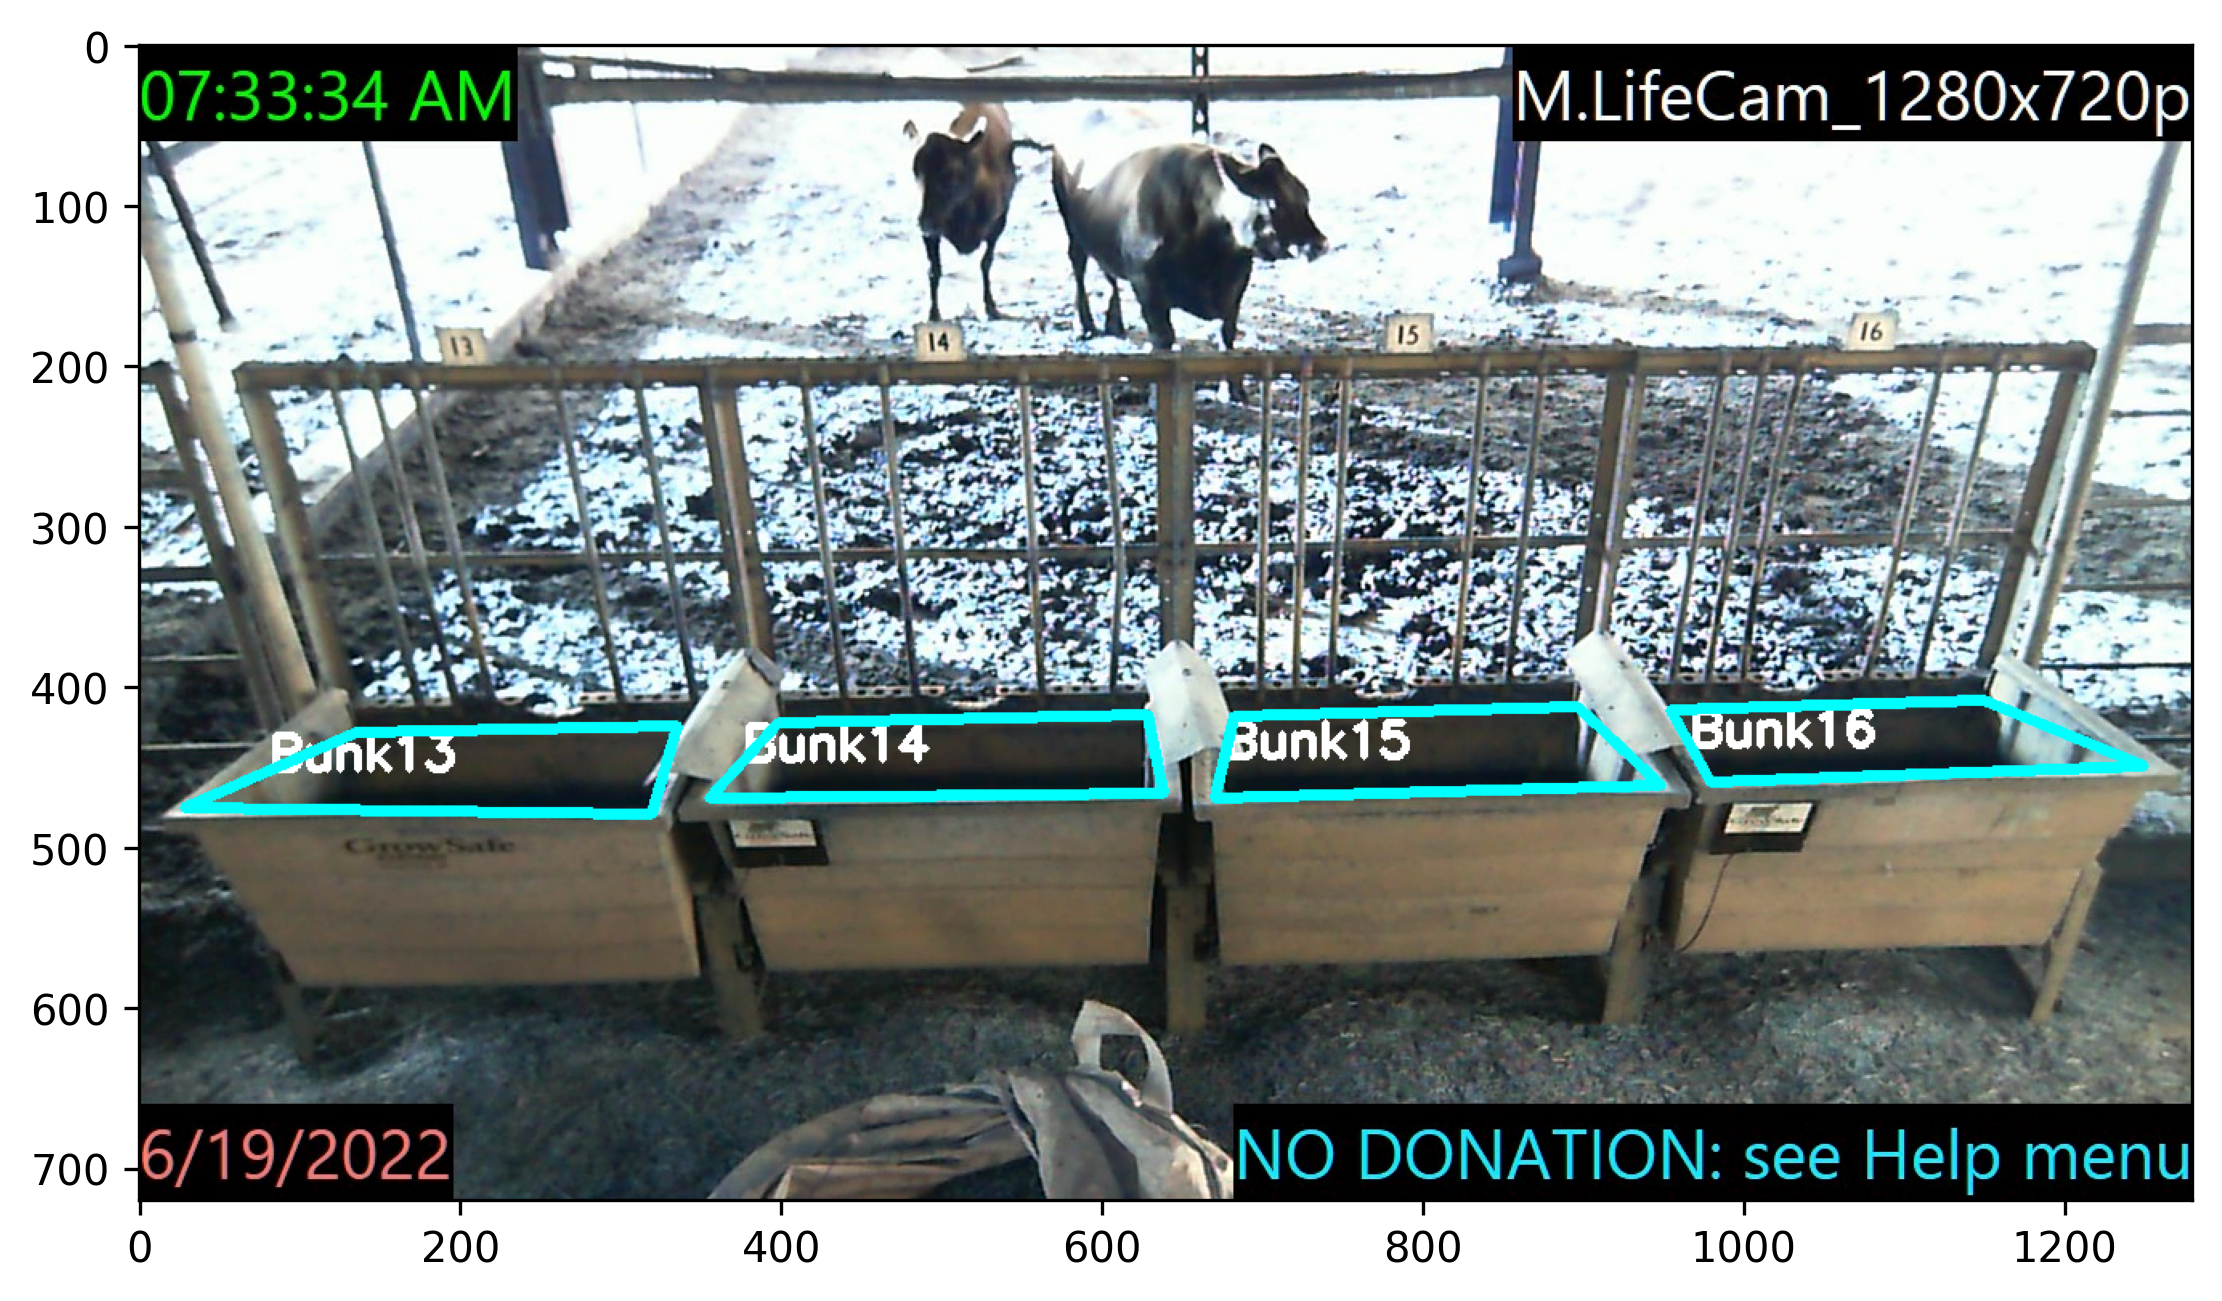

In [2]:
fig, ax = plt.subplots(figsize=(10,5),dpi=300)

    
img = cv2.imread("rec_2022_06_19_07_33_30_Moment.jpg")
studyzones='rec_2022_06_19_07_33_30_Moment.json'

pixelzones = {}
with open(studyzones, 'r') as json_file:
    zones = json.load(json_file)
    for each in (zones['shapes']):
        pixelzones.update({each['label']:each['points']})
for zonename,check_zone in pixelzones.items():
    pts = np.array(check_zone, np.int32)

    p1,p2 = (pts[0],pts[1])
    im=cv2.putText(img,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 3)

    pts = pts.reshape((-1, 1, 2))
    im=cv2.polylines(img,[pts],True,(0,255,255),5)
plt.imshow(im)


# Build a function to read mask_data (md) and use different threshold. 

In [39]:
# file_path='D:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_07_36_04.mp4'
    # file_path='TAMU BCS Animal Example Video/2022 05 25 - TAMU BCS Sample Video GS - GoPro FullHD 1920x1080 30fps.MP4'
def ft(file_path,md_path,threshold = 0.5):    
    
    studyzones='rec_2022_06_19_07_33_30_Moment.json'

    pixelzones = {}
    with open(studyzones, 'r') as json_file:
        zones = json.load(json_file)
        for each in (zones['shapes']):
            pixelzones.update({each['label']:each['points']})
    # file_path = file_path[:-16]+'.mp4'
    feed_time = {}
    
    md = np.load(md_path,allow_pickle=True).item()    
    video_capture = cv2.VideoCapture(file_path)
    w = int(video_capture.get(3))
    h = int(video_capture.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(file_path[:-4]+'_feed_{}.avi'.format(threshold), fourcc, fps, (w, h))

    mask_data={}
    frame_number=0
    while True:
        feed_time.update({frame_number:[]})
        ret, frame = video_capture.read()  # frame shape 640*480*3
        if ret != True:
            break
        img=frame.copy()
        if len(md[frame_number][3])==0:
            im=img
        for mask in md[frame_number][3]:
            mask2= np.where(mask[0,:,:]>threshold,1,0)
            mask3=cv2.cvtColor(mask2.astype("uint8"),cv2.COLOR_GRAY2RGB)*255 
            im = cv2.addWeighted(img, 1, mask3, 0.5,1)
            print(np.sum(mask3))
            for zonename,check_zone in pixelzones.items():
                #Put text and polygon lines
                pts = np.array(check_zone, np.int32)
                p1,p2,p3,p4 = pts
                im=cv2.putText(im,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 3)
                ptss = pts.reshape((-1, 1, 2))
                im=cv2.polylines(im,[ptss],True,(0,255,255),5)
                # Build a mask for each bunk
                bunk_mask = np.zeros((h,w))
                bunk_mask = cv2.fillPoly(bunk_mask, np.array([pts]).astype("int"), 1)

                combined = bunk_mask+mask2
                unique, counts = np.unique(combined, return_counts=True)
                # im=cv2.putText(im,str(unique),tuple((np.array([int(x) for x in p2]))),cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 3)
                if 2 in dict(zip(unique, counts)).keys():
                    im=cv2.putText(im,zonename+":FEEDING",tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 3)
                # save feeding time
                    feed_time[frame_number].append([zonename])
                # else:im=img

        im=cv2.putText(im,"Frame:"+str(frame_number)+' FPS:'+str(fps),(400,50),cv2.FONT_HERSHEY_SIMPLEX,1, (255,0,0), 3)

        cv2.imshow("Output", im)
        out.write(im)    
        frame_number+=1
        if cv2.waitKey(1) & 0xFF == ord('q'):

            break
    out.release()
    cv2.destroyAllWindows()

    np.save(file_path[:-4]+'_feed_time_{}.npy'.format(threshold),feed_time)
    

# ft(file_path,md_path)


# Looping through all the saved .npy mask data

In [ ]:
for file in os.listdir('E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'):
    if '.npy' in file:
        if os.path.isdir('E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file):
            file_path = 'E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file[:-16]+'.mp4'
            md_path = 'E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file+'/'+file
            print(file_path,'\n',md_path)
            # if os.path.isfile(file_path[:-4]+'_feed_time.npy'):
            #     print('Skip:'+file_path)
            #     continue
            ft(file_path,md_path)


In [ ]:
file_path[:-16]

In [ ]:
file_path

In [ ]:
md_path

# Read data from the physical sensor as ground truth (GT)

In [17]:
sensors = pd.read_excel("E:/TAMU Animal Video/2022 06 20 - BCS Data - EDITED ALL DATA.xlsx")
sensors = sensors.set_index(pd.to_datetime(sensors['Time_label']))

# Plot GT of one scale on one date

Text(0, 0.5, 'Second')

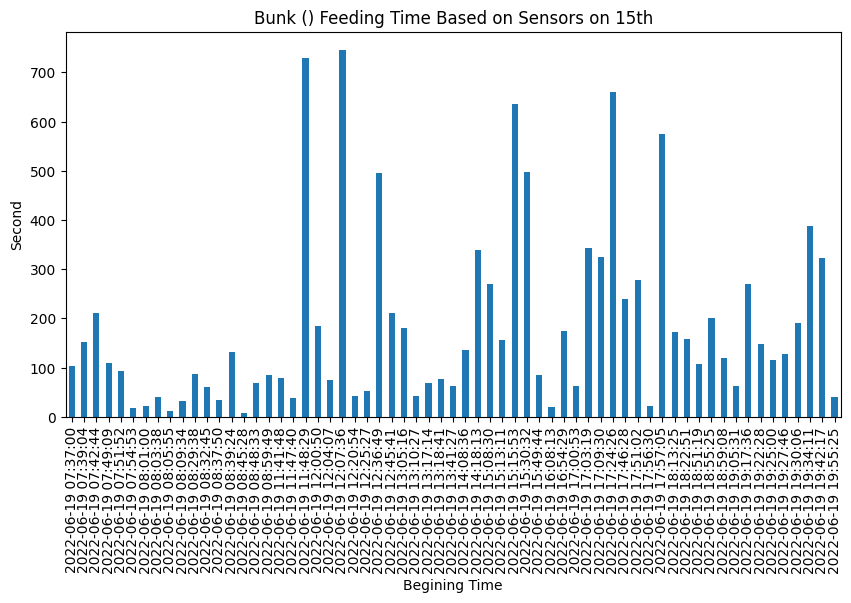

In [34]:
date=19
scale_number=15
scales  = sensors[sensors.index.day==date]
scale = scales.loc[scales['Scale']==scale_number]
scale

fig, ax = plt.subplots(figsize=(10,5))

scale['Duration'].plot.bar()

plt.title('Bunk () Feeding Time Based on Sensors on {}th'.format(scale_number,date))
plt.xlabel("Begining Time")
plt.ylabel("Second")

# fig.savefig('Bunk 15 sensors.png',bbox_inches='tight')

# Make GT data for each frame

In [35]:
total_gt=[]
for each in scale.iterrows():
    start = pd.to_datetime(each[1]['Time_label'])
    delta = int(each[1]['Duration'])
    end = start+pd.Timedelta(delta,"seconds")
    total_gt.extend(pd.date_range(start, end,freq='100ms'))

In [36]:
pd.DataFrame(total_gt)

0
0      2022-06-19 07:37:00.000
1      2022-06-19 07:37:00.100
2      2022-06-19 07:37:00.200
3      2022-06-19 07:37:00.300
4      2022-06-19 07:37:00.400
...                        ...
115978 2022-06-19 19:56:05.600
115979 2022-06-19 19:56:05.700
115980 2022-06-19 19:56:05.800
115981 2022-06-19 19:56:05.900
115982 2022-06-19 19:56:06.000

[115983 rows x 1 columns]

# with threshold 0.5

In [28]:
n=0
fps=10
video_window=[]
cv_time = {i:[] for i in ['Bunk13','Bunk14','Bunk15','Bunk16']}
for file in os.listdir('E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'):
    if '.npy' in file:
        if os.path.isdir('E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file):
            file_path = 'E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file[:-16]+'.mp4'
            # md_path = 'D:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/'+file+'/'+file
            # print(file_path[:-4]+'.npy')
            if os.path.isfile(file_path[:-4]+'_feed_time.npy'):
                time_data  =  np.load(file_path[:-4]+'_feed_time.npy',allow_pickle=True).item()
                print(file_path[:-4]+'_feed_time.npy')
                idx=file_path.find('rec_2022_06_19_')
                idx2=file_path.find('.mp4')
                hour,minute,second=(file_path[idx+9+6:idx2].split('_'))
                
                # get start and end time for each video
                df = pd.DataFrame( {"year": [2022], "month": [6], "day": [19], "hour": [int(hour)],"minute":[int(minute)],"second":[int(second)]})
                start = pd.to_datetime(df)
                delta = list(time_data.keys())[-1]/fps
                end = start+pd.Timedelta(delta,"seconds")
                # print(start,end)
                video_window.extend(pd.date_range(start[0], end[0],freq='100ms'))
                for i in ['Bunk13','Bunk14','Bunk15','Bunk16']:
                    # print(i)
                    for k, v in time_data.items():
                        s = k/fps
                        current_time = start[0]+pd.Timedelta(s,"seconds")
                        # print(i,v)                
                        if [i] in v:
                            cv_time[i].append([current_time,1])
                            # print(i,v)
                        else:
                            cv_time[i].append([current_time,0])


E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_07_20_40_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_07_48_54_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_18_04_54_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_18_45_58_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_19_11_38_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_19_14_12_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 - Microsoft_LifeCam_1080x720_Nodes_13to16/rec_2022_06_19_19_34_44_feed_time.npy
E:/TAMU Animal Video/2022 06 19 - BCS Video/2022 06 19 

In [29]:
len(video_window)

21574

# Meausre all 4 bunks

In [30]:
pd.DataFrame(video_window).to_csv('video_window.csv')

In [31]:
pd.to_datetime(pd.read_csv('video_window.csv')['0'].index, unit='s')

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 05:59:24', '1970-01-01 05:59:25',
               '1970-01-01 05:59:26', '1970-01-01 05:59:27',
               '1970-01-01 05:59:28', '1970-01-01 05:59:29',
               '1970-01-01 05:59:30', '1970-01-01 05:59:31',
               '1970-01-01 05:59:32', '1970-01-01 05:59:33'],
              dtype='datetime64[ns]', length=21574, freq=None)

In [37]:
i[4:]

'16'

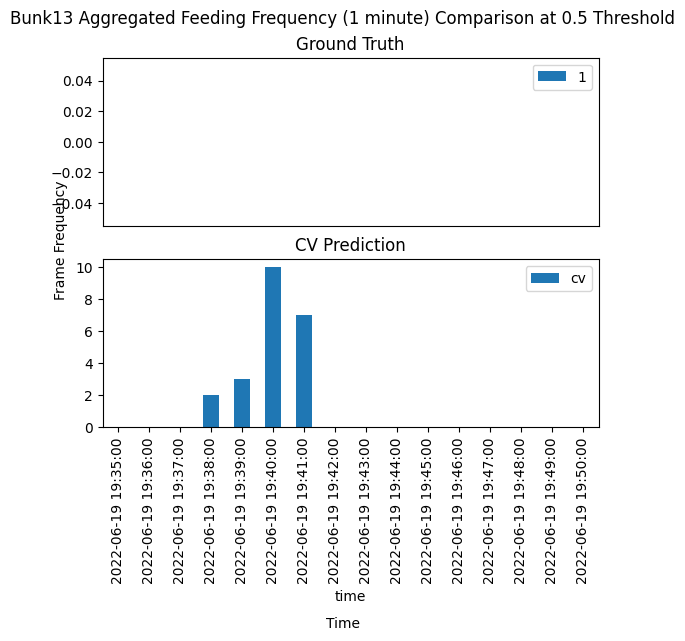

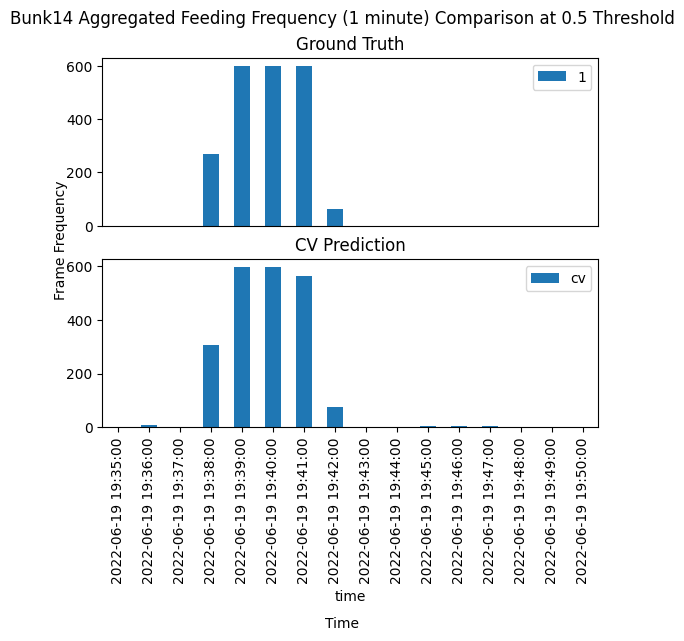

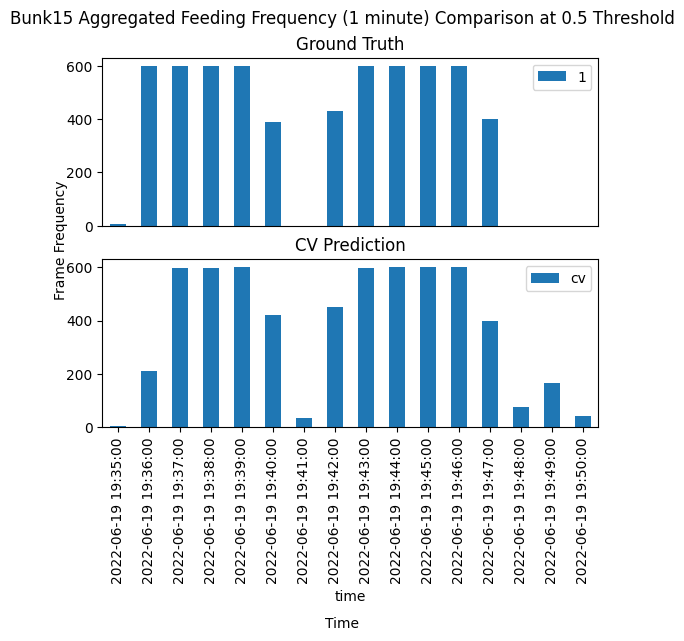

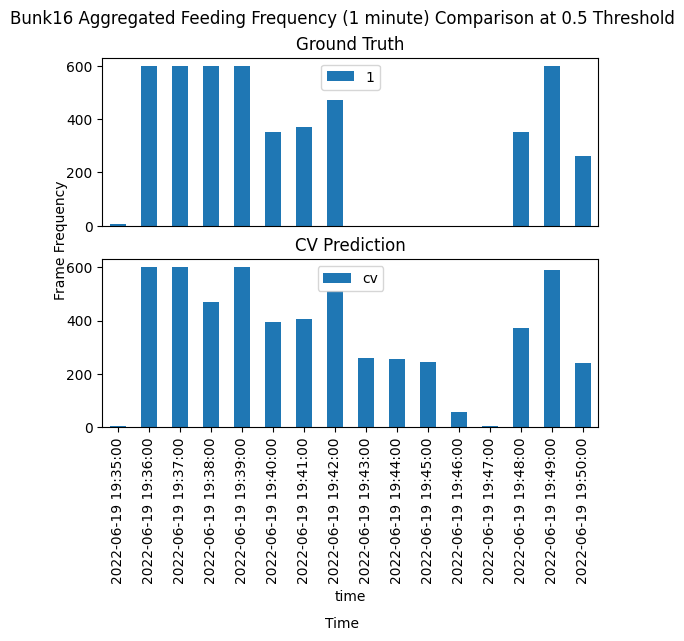

In [38]:

for i in ['Bunk13','Bunk14','Bunk15','Bunk16']:
    scale  = sensors[sensors.index.day==19]
    index= int(i[4:])
    scale = scale.loc[scale['Scale']==index]
    
    total_gt=[]
    for each in scale.iterrows():
        start = pd.to_datetime(each[1]['Time_label'])
        delta = int(each[1]['Duration'])
        end = start+pd.Timedelta(delta,"seconds")
        total_gt.extend(pd.date_range(start, end,freq='100ms'))
    
    gt=[]
    for each in video_window:
        if each in total_gt:
            gt.append([each,1])
        else:
            gt.append([each,0])
    
    
    # pd.DataFrame(cv_time[i]).to_csv('CV_{}.csv'.format(i))
    df=pd.read_csv('CV_{}.csv'.format(i))
    df['time'] = pd.to_datetime(df['0'])
    df['cv']=df['1']
    # df[['cv','time']].set_index('time').iloc[10000:19000].resample('1min').agg('sum').plot.bar()
    # plt.title(i)
    # df[['1','time']].set_index('time').resample('1min').agg('sum').plot.bar()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=1)

    pd.DataFrame(gt).set_index(0).iloc[10000:19000].resample('1min').agg('sum').plot.bar(ax=axes[0],label='gt')
    axes[0].set_title('Ground Truth')
    axes[0].xaxis.set_visible(False)

    df[['cv','time']].set_index('time').iloc[10000:19000].resample('1min').agg('sum').plot.bar(ax=axes[1])
    axes[1].set_title('CV Prediction')
    fig.suptitle("{} Aggregated Feeding Frequency (1 minute) Comparison at 0.5 Threshold".format(i))

    fig.text(0.06, 0.5, 'Frame Frequency', ha='center', va='center', rotation='vertical')
    fig.text(0.5, -0.3, 'Time', ha='center',va='center')

    # fig.savefig('Bunk 15 0.5.png',bbox_inches='tight')
    # break

# calculate precision and recall

In [40]:
type(video_window)

list

In [41]:
gt=[]
for each in video_window:
    if each in total_gt:
        gt.append([each,1])
    else:
        gt.append([each,0])

In [42]:
pd.DataFrame(gt).set_index(0)

1
0                         
2022-06-19 07:20:40.000  0
2022-06-19 07:20:40.100  0
2022-06-19 07:20:40.200  0
2022-06-19 07:20:40.300  0
2022-06-19 07:20:40.400  0
...                     ..
2022-06-19 19:55:15.600  0
2022-06-19 19:55:15.700  0
2022-06-19 19:55:15.800  0
2022-06-19 19:55:15.900  0
2022-06-19 19:55:16.000  0

[21574 rows x 1 columns]

In [43]:
total_gt

[Timestamp('2022-06-19 07:39:44', freq='100L'),
 Timestamp('2022-06-19 07:39:44.100000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.200000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.300000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.400000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.500000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.600000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.700000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.800000', freq='100L'),
 Timestamp('2022-06-19 07:39:44.900000', freq='100L'),
 Timestamp('2022-06-19 07:39:45', freq='100L'),
 Timestamp('2022-06-19 07:39:45.100000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.200000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.300000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.400000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.500000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.600000', freq='100L'),
 Timestamp('2022-06-19 07:39:45.700000', freq='100L'),
 Timestamp('2022-06-19 0

In [44]:
result  =  pd.DataFrame(gt)[1]+pd.DataFrame(cv_time['Bunk15'])[1]

In [45]:
pd.DataFrame(gt)[1].shape

(21574,)

In [46]:
pd.DataFrame(cv_time['Bunk15'])[1].value_counts()

0    11024
1    10550
Name: 1, dtype: int64

In [47]:
result.value_counts()

1    8762
0    7518
2    5294
Name: 1, dtype: int64

In [48]:
precision = result.value_counts()[2]/pd.DataFrame(gt)[1].value_counts()[1]

In [49]:
precision

0.6015909090909091

In [50]:
recall = result.value_counts()[2]/pd.DataFrame(cv_time['Bunk15'])[1].value_counts()[1]

In [51]:
recall

0.5018009478672986

In [52]:
accuracy_score = (result.value_counts()[2]+result.value_counts()[0])/len(result)

In [53]:
accuracy_score

0.5938629832205432

In [54]:
F1Score = 2*precision*recall/ (precision +recall)

In [55]:
F1Score

0.5471834625322997

In [56]:
from sklearn.metrics import confusion_matrix,classification_report

In [57]:
confusion_matrix(pd.DataFrame(gt)[1],pd.DataFrame(cv_time['Bunk15'])[1])

array([[7518, 5256],
       [3506, 5294]], dtype=int64)

In [58]:
print(classification_report(pd.DataFrame(gt)[1],pd.DataFrame(cv_time['Bunk15'])[1]))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63     12774
           1       0.50      0.60      0.55      8800

    accuracy                           0.59     21574
   macro avg       0.59      0.60      0.59     21574
weighted avg       0.61      0.59      0.60     21574



In [59]:
report = classification_report(pd.DataFrame(gt)[1],pd.DataFrame(cv_time['Bunk15'])[1], output_dict=True)

In [60]:
df = pd.DataFrame(report)

In [ ]:
df.to_csv('report.csv')

In [170]:
df

0            1  accuracy     macro avg  weighted avg
precision      0.681967     0.501801  0.593863      0.591884      0.608477
recall         0.588539     0.601591  0.593863      0.595065      0.593863
f1-score       0.631818     0.547183  0.593863      0.589501      0.597296
support    12774.000000  8800.000000  0.593863  21574.000000  21574.000000

In [ ]:
gt

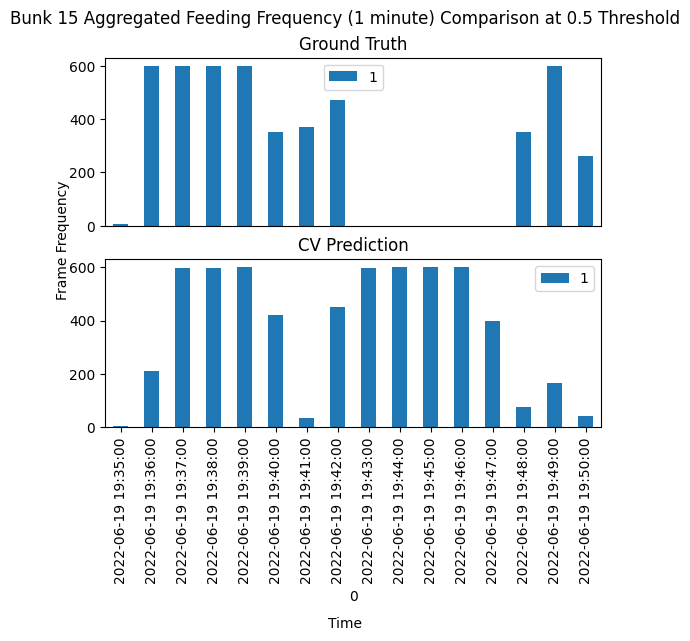

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=1)

pd.DataFrame(gt).set_index(0).iloc[10000:19000].resample('1min').agg('sum').plot.bar(ax=axes[0])
axes[0].set_title('Ground Truth')
axes[0].xaxis.set_visible(False)

pd.DataFrame(cv_time['Bunk15']).set_index(0).iloc[10000:19000].resample('1min').agg('sum').plot.bar(ax=axes[1])
axes[1].set_title('CV Prediction')
fig.suptitle("Bunk 15 Aggregated Feeding Frequency (1 minute) Comparison at 0.5 Threshold")

fig.text(0.06, 0.5, 'Frame Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.3, 'Time', ha='center',va='center')

fig.savefig('Bunk 15 0.5.png',bbox_inches='tight')

In [ ]:
pd.DataFrame(gt).set_index(0).iloc[10000:19000].to_csv('Sensor_data.csv')

In [ ]:
pd.DataFrame(cv_time['Bunk15']).set_index(0).iloc[10000:19000].to_csv('CV_data.csv')

In [ ]:
cv_time.keys()